In [1]:
# Importando as bibliotecas necessárias

import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    roc_curve,
    roc_auc_score,
    auc
)

In [3]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  786M    0 15826    0     0   102k      0  2:10:21 --:--:--  2:10:21  103k
  2  786M    2 21.5M    0     0  19.1M      0  0:00:41  0:00:01  0:00:40 19.1M
  6  786M    6 49.1M    0     0  22.9M      0  0:00:34  0:00:02  0:00:32 22.9M
  9  786M    9 75.6M    0     0  24.1M      0  0:00:32  0:00:03  0:00:29 24.1M
 13  786M   13  103M    0     0  25.0M      0  0:00:31  0:00:04  0:00:27 25.0M
 16  786M   16  131M    0     0  25.7M      0  0:00:30  0:00:05  0:00:25 26.4M
 19  786M   19  157M    0     0  25.6M      0  0:00:30  0:00:06  0:00:24 27.1M
 23  786M   23  184M    0     0  25.8M      0  0:00:30  0:00:07  0:00:23 27.1M
 26  786M   26  210M    0     0  25.8M      0  0:00:30  0:00:08  0:00:22 26.9M
 30  786M   30  237M    0     0  26.0M      0  0:00

In [3]:
# Deletando imagens corrompidas
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1578 images.


In [2]:
image_size = (180, 180)
batch_size = 128

# Carregando todo o dataset
full_ds = keras.utils.image_dataset_from_directory(
    "PetImages",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    seed=1337  # Definindo seed para splits reproduzíveis
)

# Calculando tamanho do dataset e dos splits
def split_dataset(dataset, train_ratio=0.7, val_ratio=0.20, test_ratio=0.10):
    dataset_size = tf.data.experimental.cardinality(dataset).numpy()
    
    train_size = int(train_ratio * dataset_size)
    val_size = int(val_ratio * dataset_size)
    
    # Criando splits
    train_ds = dataset.take(train_size)
    remaining = dataset.skip(train_size)
    val_ds = remaining.take(val_size)
    test_ds = remaining.skip(val_size)

    return train_ds, val_ds, test_ds

# Dividir em train (70%), validation (20%) e test (10%)
train_ds, val_ds, test_ds = split_dataset(full_ds)

# Otimizações de pipeline
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)

Found 23422 files belonging to 2 classes.


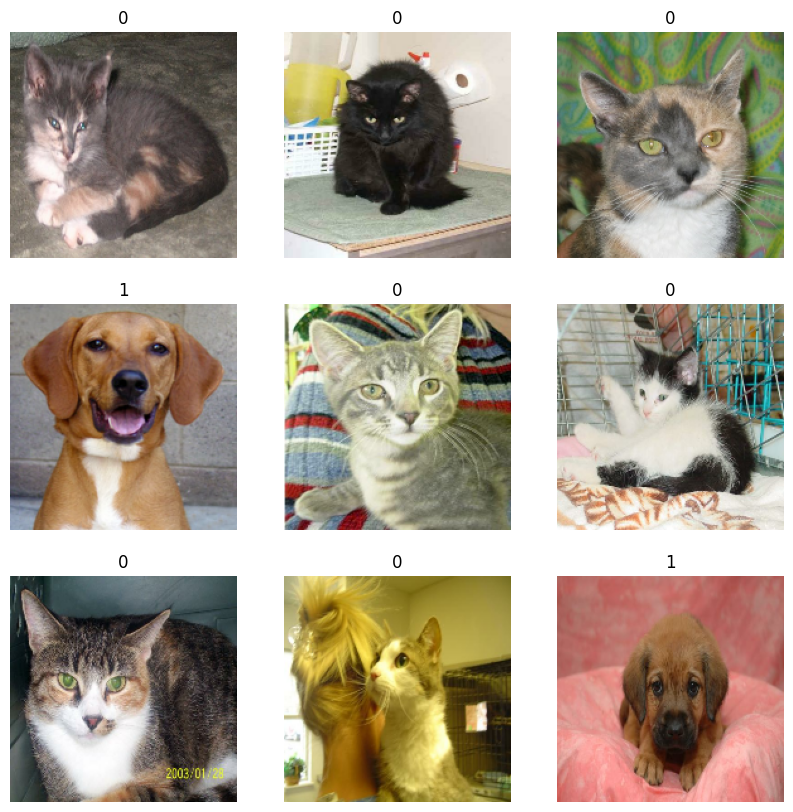

In [15]:
# Plotando imagens de exemplo
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [3]:
# Definindo Data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.08),
    layers.RandomTranslation(0.05, 0.05),
])

# Construindo Rede Neural
def build_model(input_shape=(180,180,3)):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)

  # Bloco 1 (5x5 + 3x3), 64 filtros
    x = layers.Conv2D(64, 5, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.Conv2D(64, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    # Bloco 2, 128 filtros (duplo)
    for _ in range(2):
        x = layers.Conv2D(128, 3, padding="same", use_bias=False)(x)
        x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    # Bloco 3, 256 filtros (duplo)
    for _ in range(2):
        x = layers.Conv2D(256, 3, padding="same", use_bias=False)(x)
        x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    # Bloco 4, 512 filtros (duplo)
    for _ in range(2):
        x = layers.Conv2D(512, 3, padding="same", use_bias=False)(x)
        x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(2e-4),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 64)      4800      
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 64)     256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 180, 180, 64)      0         
                                                             

In [29]:
# Estabelecendo Checkpoints e treinando modelo
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    filepath="checkpoints/best_v3.keras",
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

reduce_lr_cb = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

earlystop_cb = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=9,                 # paciência um pouco maior para explorar após platô
    restore_best_weights=True,
    verbose=1
)

callbacks = [checkpoint_cb, reduce_lr_cb, earlystop_cb]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
128/128 [==============================] - ETA: 0s - loss: 0.6469 - accuracy: 0.6408
Epoch 1: val_loss improved from inf to 0.75151, saving model to checkpoints\best_v3.keras
128/128 [==============================] - 63s 484ms/step - loss: 0.6469 - accuracy: 0.6408 - val_loss: 0.7515 - val_accuracy: 0.4855 - lr: 2.0000e-04
Epoch 2/30
128/128 [==============================] - ETA: 0s - loss: 0.5566 - accuracy: 0.7157
Epoch 2: val_loss did not improve from 0.75151
128/128 [==============================] - 62s 482ms/step - loss: 0.5566 - accuracy: 0.7157 - val_loss: 0.8079 - val_accuracy: 0.4941 - lr: 2.0000e-04
Epoch 3/30
128/128 [==============================] - ETA: 0s - loss: 0.4998 - accuracy: 0.7568
Epoch 3: val_loss did not improve from 0.75151

Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
128/128 [==============================] - 62s 485ms/step - loss: 0.4998 - accuracy: 0.7568 - val_loss: 1.1534 - val_accuracy: 0.4907 - lr: 2.0000e-0

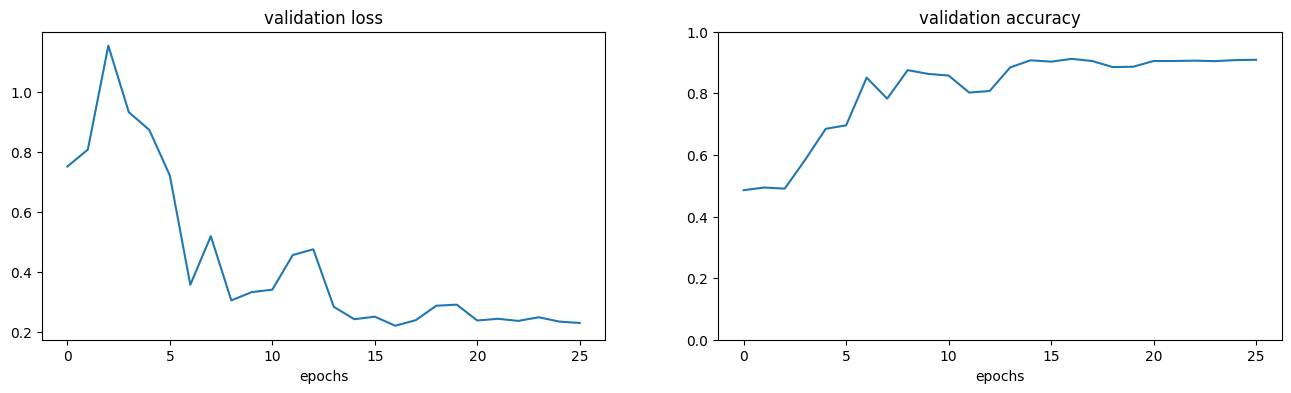

In [30]:
# Exibindo resultados no dataset de validação
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [28]:
# Resultados no dataset de teste
best_model = keras.models.load_model("checkpoints/best_v3.keras") 

test_loss, test_acc = best_model.evaluate(test_ds)
print(f"Teste - Loss: {test_loss:.4f} | Acc: {test_acc:.4f}")

19/19 [==============================] - 8s 118ms/step - loss: 0.2223 - accuracy: 0.9132
Teste - Loss: 0.2223 | Acc: 0.9132


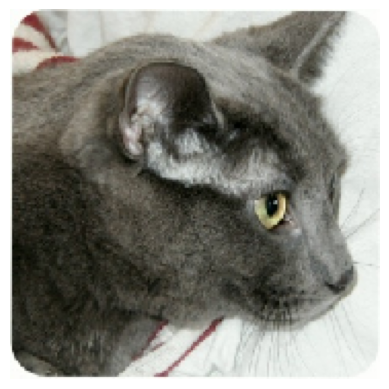

This image is 99.51% cat and 0.49% dog.


In [3]:
# Verificando a previsão do modelo para uma imagem 
model = keras.models.load_model("checkpoints/best_v3.keras")

image_size = (180, 180)  
img_path = Path("PetImages/Cat/6779.jpg")  

img = keras.utils.load_img(str(img_path), target_size=image_size)
plt.imshow(img); plt.axis("off"); plt.show()

img_array = keras.utils.img_to_array(img)         
img_array = tf.expand_dims(img_array, 0)  

pred = model.predict(img_array, verbose=0)          
score = pred.item()

print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

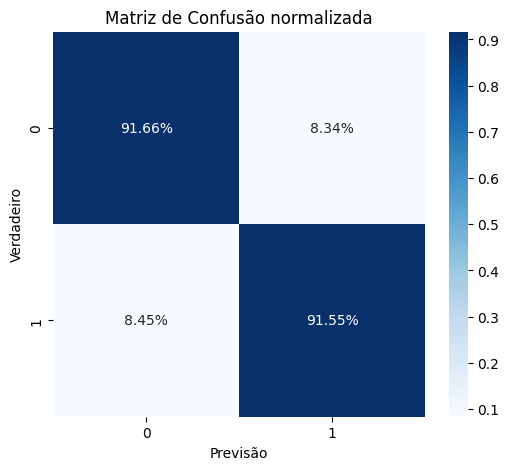

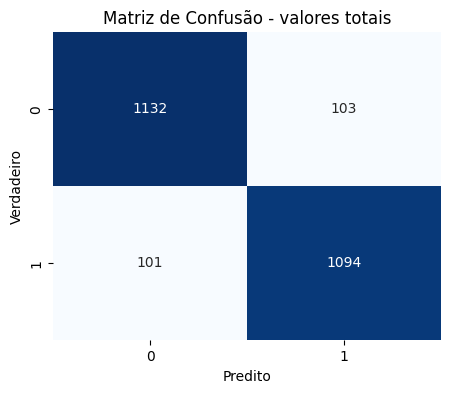

In [4]:
# Converter dataset de teste em arrays (imagens e rótulos)
def ds_to_xy(ds):
    xs, ys = [], []
    for batch_x, batch_y in ds:
        xs.append(batch_x.numpy())
        ys.append(batch_y.numpy())
    return np.vstack(xs), np.hstack(ys)

X_test, y_test = ds_to_xy(test_ds)

# Predições de probabilidade (saída sigmoid)
y_prob = model.predict(X_test, batch_size=64).ravel()

# Binarizar com threshold padrão 0.5
y_pred = (y_prob >= 0.5).astype(int)

# Matriz de confusão e Matriz de confusão normalizada
cm = confusion_matrix(y_test, y_pred)
cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')

#Matriz normalizada
plt.figure(figsize=(6,5)) 
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', cbar=True)
plt.xlabel("Previsão")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão normalizada")
plt.show()

print()

#Matriz com valores absolutos
plt.figure(figsize=(5,4)) 
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão - valores totais")
plt.show()

In [5]:
# Calculando métricas de avaliação
vn, fp, fn, vp = cm.ravel()

Acurácia  = (vp + vn) / (vp + vn + fp + fn)
Precisão = vp / (vp + fp) if (vp + fp) > 0 else 0.0  
Sensibilidade = vp / (vp + fn) if (vp + fn) > 0 else 0.0  
Especificidade = vn / (vn + fp) if (vn + fp) > 0 else 0.0
F_Score = (2*vp) / (2*vp + fp + fn) if (2*vp + fp + fn) > 0 else 0.0  

auc_value = roc_auc_score(y_test, y_prob)

print(f"VP={vp}, VN={vn}, FP={fp}, FN={fn}")
print(f"Acurácia: {Acurácia:.2f}")
print(f"Precisão: {Precisão:.2f}")
print(f"Sensibilidade/Recall: {Sensibilidade:.2f}")
print(f"Especificidade: {Especificidade:.2f}")
print(f"F1-Score: {F_Score:.2f}")
print(f"AUC - ROC Score: {auc_value:.2f}")

VP=1094, VN=1132, FP=103, FN=101
Acurácia: 0.92
Precisão: 0.91
Sensibilidade/Recall: 0.92
Especificidade: 0.92
F1-Score: 0.91
AUC - ROC Score: 0.97


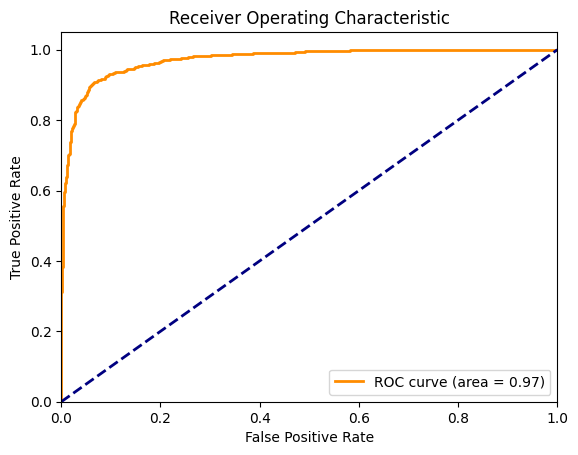

In [7]:
# Construindo curva AUC-ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()